In [12]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os 
import random
import numpy as np 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 图像的Normalize

In [13]:
data_trans=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [14]:
data_trans_227=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [15]:
data_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [16]:
data_test_227=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [17]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=data_trans)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=data_trans)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [19]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [20]:
print(len(train_data),len(valid_data),len(test_data))

45000 5000 10000


In [21]:
batch_size=64

In [23]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

# 定义GoogLeNet模型

In [24]:
class Inception(nn.Module):
    def __init__(self,in_planes,n1x1,n3x3red,n3x3,n5x5red,n5x5,pool_planes):
        super(Inception,self).__init__()
        self.b1=nn.Sequential(
            nn.Conv2d(in_planes,n1x1,kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        
        self.b2=nn.Sequential(
            nn.Conv2d(in_planes,n3x3red,kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red,n3x3,kernel_size=3,padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )
        
        self.b3=nn.Sequential(
            nn.Conv2d(in_planes,n5x5red,kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red,n5x5,kernel_size=5,padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )
        
        self.b4=nn.Sequential(
            nn.MaxPool2d(3,stride=1,padding=1),
            nn.Conv2d(in_planes,pool_planes,kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
        
    def forward(self,x):
        x1=self.b1(x)
        x2=self.b2(x)
        x3=self.b3(x)
        x4=self.b4(x)
        #concat4层输入在一起
        return torch.cat([x1,x2,x3,x4],1)
    

In [25]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet,self).__init__()
        self.feature_block=nn.Sequential(
            nn.Conv2d(3,192,kernel_size=3,padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.a3=Inception(192,64,96,128,16,32,32)
        self.b3=Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool=nn.MaxPool2d(3,stride=2,padding=1)
        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool=nn.AvgPool2d(8,stride=1)
        self.linear=nn.Linear(1024,10)
    
    def forward(self,x):
        out=self.feature_block(x)
        out=self.a3(out)
        out=self.b3(out)
        out=self.maxpool(out)
        out=self.a4(out)
        out=self.b4(out)
        out=self.c4(out)
        out=self.d4(out)
        out=self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 载入模型并训练

In [26]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
model_dir='/content/drive/My Drive/Colab Notebooks/models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [28]:
device

device(type='cuda')

In [29]:
model=GoogLeNet().to(device)
model_path=os.path.join(model_dir,'googlenet_mnist.pt')

In [30]:
optimizer=optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss()

## 定义计算精确度方法

In [31]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

## 定义训练方法

In [32]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## 定义评测方法

In [33]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [34]:
epochs=30
best_valid_loss=float('inf')

In [ ]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:1.3853845896030015|Train Acc:0.48539595170454547|Val Loss:1.5747301910496965|Val Acc:0.504746835443038
Epoch:2|Train Loss:0.9453265175900676|Train Acc:0.6628196022727273|Val Loss:0.8707884346382527|Val Acc:0.6948180379746836
Epoch:3|Train Loss:0.7367098293775185|Train Acc:0.7425648082386364|Val Loss:0.763702517823328|Val Acc:0.728243670886076
Epoch:4|Train Loss:0.6261421413668855|Train Acc:0.7822487571022727|Val Loss:0.5904473669921295|Val Acc:0.7998417721518988
Epoch:5|Train Loss:0.5390790349549868|Train Acc:0.8138760653409091|Val Loss:0.6017727195462094|Val Acc:0.7962816455696202
Epoch:6|Train Loss:0.4887456259139898|Train Acc:0.8301225142045454|Val Loss:0.49572475348846823|Val Acc:0.8263449367088608
Epoch:7|Train Loss:0.4452460249250924|Train Acc:0.8451038707386364|Val Loss:0.5220960378646851|Val Acc:0.8239715189873418
Epoch:8|Train Loss:0.4059314794457433|Train Acc:0.8593084161931818|Val Loss:0.4795627469503427|Val Acc:0.8395965189873418
Epoch:9|Train Loss:0.3714

In [ ]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.36430715475302594 | Test Acc: 0.8950039808917197 |


# 模型的评测

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [36]:
prediction=[]
groundtruth=[]

In [37]:
def evaluate2(model,device,iterator,criterion):
  epoch_loss=0
  epoch_acc=0
  model.eval()
  with torch.no_grad():
    for (x,y) in iterator:
      x=x.to(device)
      y=y.to(device)
      fx=model(x)
      loss=criterion(fx,y)
      prediction.append(fx)
      groundtruth.append(y)
      acc=accu(fx,y)
      epoch_loss+=loss.item()
      epoch_acc+=acc.item()
  return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [38]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate2(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.3589741385002045 | Test Acc: 0.897093949044586 |


In [39]:
pred=torch.cat(prediction).cpu().numpy()

In [40]:
pred.shape

(10000, 10)

In [41]:
pred[0]

array([ -7.7369275, -13.3294325,  -7.250525 ,   2.1735716,  -8.96631  ,
         0.7526249,  -4.722032 ,  -5.252516 ,  -6.1589355, -16.670345 ],
      dtype=float32)

In [42]:
gt=torch.cat(groundtruth).cpu().numpy()

In [43]:
gt.shape

(10000,)

In [44]:
fpr=dict()
tpr=dict()
prc=dict()
rcl=dict()
roc_auc=dict()
ap=dict()

In [45]:
gt_one_hot=np.eye(10)[gt.reshape(-1)]#groundtruth的onehot化

In [46]:
gt_one_hot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [47]:
pred_soft=F.softmax(torch.cat(prediction).cpu()).cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [48]:
pred_soft[0]

array([3.9928804e-05, 1.4876217e-07, 6.4942389e-05, 8.0419540e-01,
       1.1678113e-05, 1.9420138e-01, 8.1402727e-04, 4.7890880e-04,
       1.9346381e-04, 5.2668634e-09], dtype=float32)

In [49]:
for i in range(10):
    fpr[i],tpr[i],_=roc_curve(gt_one_hot[:,i],pred_soft[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
    prc[i],rcl[i],_=precision_recall_curve(gt_one_hot[:,i],pred_soft[:,i])
    ap[i]=average_precision_score(gt_one_hot[:,i],pred_soft[:,i])

In [50]:
tpr[0].shape

(341,)

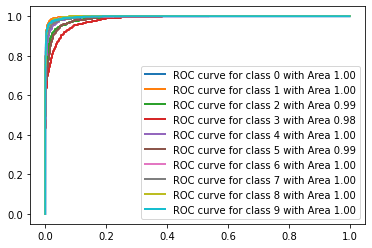

In [51]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.legend()

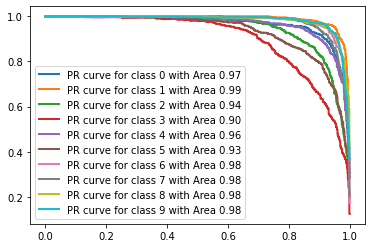

In [52]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.legend()

## Micro的实现

Micro认为所有的分类1......k都是同一类，因此将所有的gt和预测的结果合并成为1个数组来进行评判

In [54]:
gt_one_hot.ravel().shape

(100000,)

In [55]:
pred_soft.ravel().shape

(100000,)

In [56]:
fpr['micro'],tpr['micro'],_=roc_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [57]:
prc['micro'],rcl['micro'],_=precision_recall_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [58]:
ap['micro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='micro')

In [59]:
roc_auc['micro']=auc(fpr['micro'],tpr['micro'])

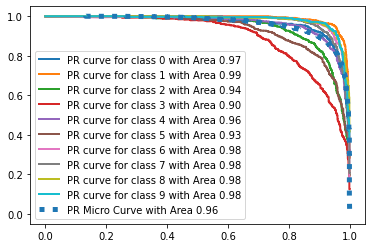

In [60]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
    
plt.legend()

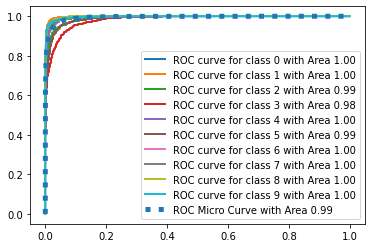

In [61]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
 
plt.legend()

## Macro的计算

In [62]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(10)]))#获得所有的fpr插值点

In [63]:
np.concatenate([fpr[i] for i in range(10)]).shape

(3573,)

In [64]:
all_prc=np.unique(np.concatenate([prc[i] for i in range(10)]))#获得所有的prc的插值点

In [65]:
mean_tpr=np.zeros_like(all_fpr)
mean_rcl=np.zeros_like(all_prc)

In [66]:
mean_tpr.shape

(645,)

In [67]:
for i in range(10):
    mean_tpr+=interp(all_fpr,fpr[i],tpr[i])
    mean_rcl+=interp(all_prc,prc[i],rcl[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
mean_tpr/=10

In [69]:
mean_rcl/=10

In [70]:
fpr['macro']=all_fpr
prc['macro']=all_prc
tpr['macro']=mean_tpr
rcl['macro']=mean_rcl
roc_auc['macro']=auc(fpr['macro'],tpr['macro'])
ap['macro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='macro')

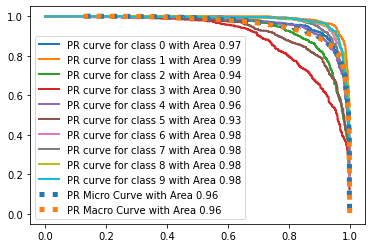

In [71]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
plt.plot(prc['macro'],rcl['macro'],lw=5,linestyle=":",label='PR Macro Curve with Area %0.2f'%(ap['macro']))
    
plt.legend()

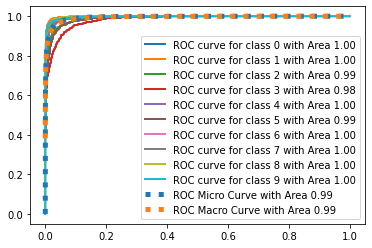

In [72]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
plt.plot(fpr['macro'],tpr['macro'],lw=5,linestyle=":",label='ROC Macro Curve with Area %0.2f'%(roc_auc['macro']))
 
plt.legend()

In [73]:
mAP=np.asanyarray([ap[i] for i in range(10)]).mean()

In [74]:
mAP

0.9606709697080758